## How to do it...

### Import relevant libaries

import tensorflow as tf
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

from numpy.random import uniform, seed
from scipy.interpolate import griddata

from matplotlib.font_manager import FontProperties
from sklearn.metrics import roc_curve

## Boilerplate Code to Plot

In [42]:
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(xvalid.iloc[ID][sorted_ix], ax)
  return ax

In [43]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']

### Import data

In [2]:
xtrain = pd.read_csv('hotel_bookings.csv')
xtrain.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


### Create x and y train and validation data sets

In [3]:
xvalid = xtrain.loc[xtrain['reservation_status_date'] >= '2017-08-01']
xtrain = xtrain.loc[xtrain['reservation_status_date'] < '2017-08-01']

In [4]:
ytrain, yvalid = xtrain['is_canceled'], xvalid['is_canceled']
xtrain.drop('is_canceled', axis = 1, inplace = True)
xvalid.drop('is_canceled', axis = 1, inplace = True)

### Drop columns that are irrelevant or may introduce data leak

In [5]:
xtrain.drop(['arrival_date_year','assigned_room_type', 'booking_changes', 'reservation_status',
             'country', 'days_in_waiting_list'], axis =1, inplace = True)

### Specify numerical and categorical feature columns

In [6]:
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

### Create one hot categorical column encoder

In [7]:
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

### Create feature columns list

In [8]:
feature_columns = []
for feature_name in cat_features:
    # Need to one-hot encode categorical features.
    vocabulary = xtrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in num_features:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

### Create input function for training and inference

In [9]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(ytrain)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    
    def input_fn():
        
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn


# Training and evaluation input functions.
train_input_fn = make_input_fn(xtrain, ytrain)
eval_input_fn = make_input_fn(xvalid, yvalid, shuffle=False, n_epochs=1)

### Build the BoostedTrees model

In [10]:
params = {
  'n_trees': 125,
  'max_depth': 5,
  'n_batches_per_layer': 1,
#   'learning_rate': 0.05, 
#   'l1_regularization': 0.00001, 
#   'l2_regularization': 0.00001,
#    'min_node_weight': 0.01,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}


est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp14hbkw50', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Plea

In [11]:
# Evaluation
results = est.evaluate(eval_input_fn)
pd.Series(results).to_frame()

INFO:tensorflow:Calling model_fn.
Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-31T12:46:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.52673s
INFO:tensorflow:Finished evaluation at 2022-01-31-12:46:12
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.7230971, accuracy_baseline = 0.9160105, auc = 0.6441458, auc_precision_recall = 0.1984468, average_loss = 0.54020387, global_step = 100, label/mean = 0.0839895, loss = 0.54020387, precision = 0.12307692, prediction/mean = 0.35884833, recall = 0.375
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning a

,0
accuracy,0.723097
accuracy_baseline,0.916010
auc,0.644146
auc_precision_recall,0.198447
average_loss,0.540204
label/mean,0.083990
loss,0.540204
precision,0.123077
prediction/mean,0.358848
recall,0.375000


In [15]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


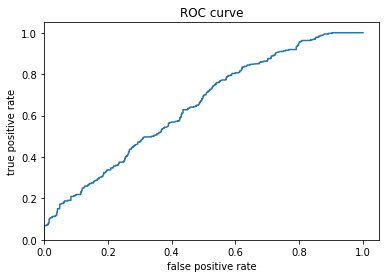

In [16]:
fpr, tpr, _ = roc_curve(yvalid, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,); plt.ylim(0,); plt.show()

In [20]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# Create DFC Pandas dataframe
labels = yvalid.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp14hbkw50', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tens

,count,mean,std,min,25%,50%,75%,max
arrival_date_week_number,3810.0,0.019534,0.021510,-0.028329,0.007607,0.014693,0.020972,0.103444
arrival_date_day_of_month,3810.0,0.017997,0.024333,-0.006491,0.004448,0.009576,0.013028,0.093064
lead_time,3810.0,0.001136,0.064350,-0.220563,-0.032471,0.014071,0.040543,0.149782
agent,3810.0,0.006533,0.020112,-0.057155,-0.003987,-0.000960,0.010693,0.110177
deposit_type,3810.0,-0.022725,0.013911,-0.078625,-0.025121,-0.022185,-0.021323,0.151777
previous_cancellations,3810.0,-0.022863,0.019657,-0.073369,-0.032487,-0.026416,-0.008149,0.263954
total_of_special_requests,3810.0,-0.019264,0.051435,-0.096341,-0.051117,-0.031449,-0.004199,0.125408
adr,3810.0,0.013175,0.019918,-0.040386,0.000190,0.006793,0.022635,0.113073
arrival_date_month,3810.0,0.011040,0.009486,-0.028157,0.006996,0.014293,0.017400,0.068828
market_segment,3810.0,-0.001540,0.043298,-0.188564,-0.041904,0.006704,0.024417,0.095605


## How it works...

The following code block demonstrates the steps necessary to extract the feature contributions to a prediction for a particular record. For convenience and reusability, we define a function plotting a chosen record first (for easier interpretation, we want to plot feature importances using different colors, depending on whether their contribution is positive or negative):

With the boilerplate code defined, we plot the detailed graph for a specific record in a straight forward manner:

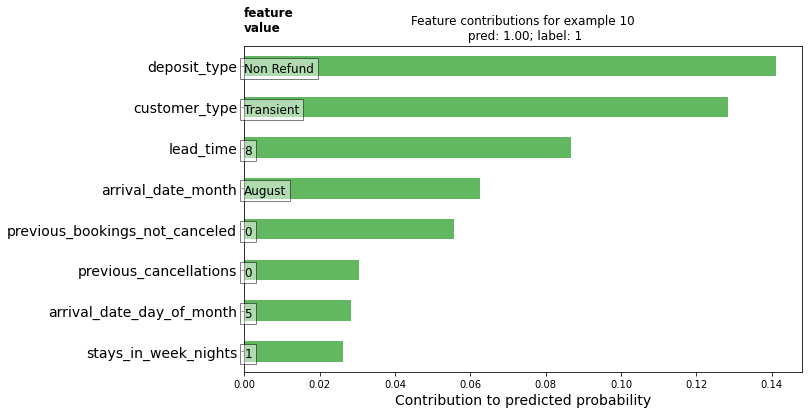

In [25]:
ID = 10
example = df_dfc.iloc[ID] # Choose ith example from evaluation set.
TOP_N = 8 # View top 8 features
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

Global interpretability refers to an understanding of the model as a whole: we will retrieve and visualize gain-based feature importances, permutation feature importances and also show aggregated DFCs.

Gain-based feature importances using est.experimental_feature_importances Permutation importances Aggregate DFCs using est.experimental_predict_with_explanations Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated (source).

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-31T13:44:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.52715s
INFO:tensorflow:Finished evaluation at 2022-01-31-13:44:04
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.7230971, accuracy_baseline = 0.9160105, auc = 0.6441458, auc_precision_recall = 0.1984468, average_loss = 0.54020387, global_step = 100, label/mean = 0.0839895, loss = 0.54020387, precision = 0.12307692, prediction/mean = 0.35884833, recall = 0.375
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-31T13:44:04
INFO:tensorflow:Graph was fi

INFO:tensorflow:Inference Time : 0.51164s
INFO:tensorflow:Finished evaluation at 2022-01-31-13:44:11
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.7131234, accuracy_baseline = 0.9160105, auc = 0.6052382, auc_precision_recall = 0.1059003, average_loss = 0.56379133, global_step = 100, label/mean = 0.0839895, loss = 0.56379133, precision = 0.10195675, prediction/mean = 0.3585645, recall = 0.309375
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-31T13:44:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.51341s
INFO:tensorflow:Finished evaluation at 2022-01-31-13:44:12
INFO:tensorflow:Saving dict for global step 100: accuracy

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-31T13:44:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.50506s
INFO:tensorflow:Finished evaluation at 2022-01-31-13:44:20
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.7230971, accuracy_baseline = 0.9160105, auc = 0.6437509, auc_precision_recall = 0.19839515, average_loss = 0.54078424, global_step = 100, label/mean = 0.0839895, loss = 0.54078424, precision = 0.12307692, prediction/mean = 0.3593652, recall = 0.375
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-31T13:44:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-31T13:44:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.50516s
INFO:tensorflow:Finished evaluation at 2022-01-31-13:44:29
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.69947505, accuracy_baseline = 0.9160105, auc = 0.6013619, auc_precision_recall = 0.18191741, average_loss = 0.58524185, global_step = 100, label/mean = 0.0839895, loss = 0.58524185, precision = 0.11412535, prediction/mean = 0.36841404, recall = 0.38125
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmp14hbkw50/model.ckpt-100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done

Text(0.5, 1.0, 'Permutation feature importance')

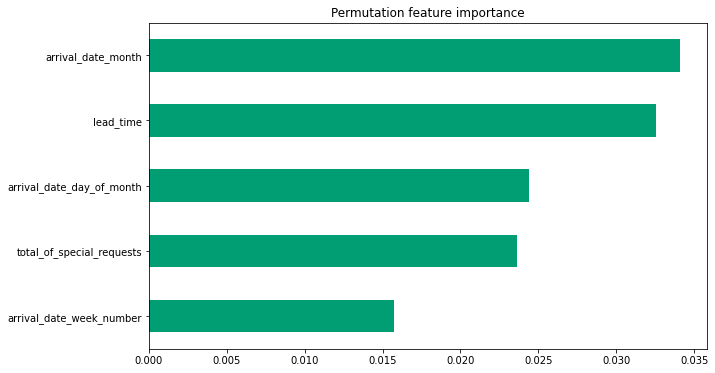

In [48]:
features = cat_features + num_features
importances = permutation_importances(est, xvalid, yvalid, accuracy_metric, features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')

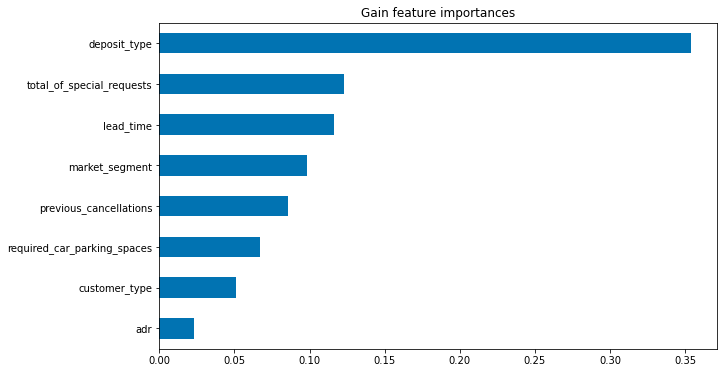

In [39]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1].plot(kind='barh', color=sns_colors[0], title='Gain feature importances',
                                 figsize=(10, 6)))
ax.grid(False, axis='y')

The absolute values of DFCs can be averaged to understand impact at a global level.

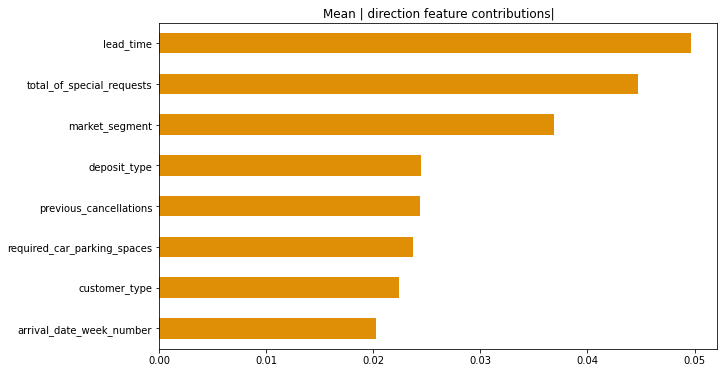

In [40]:
# Plot
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                              color=sns_colors[1],
                              title='Mean | direction feature contributions|',
                              figsize=(10, 6))
ax.grid(False, axis='y')